In [1]:
import torch
from pyqcu.torch import dslash
from pyqcu.torch.define import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (16, 16, 16, 8)
latt_size = (16, 16, 8, 8)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 8)
# latt_size = (8, 16, 16, 32)
# latt_size = (16, 16, 16, 32)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
# dtype = torch.complex32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
# clover_term = torch.zeros_like(clover_term) # just for test, just wilson

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True
tol = 1e-9

Using device: cuda


In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.1672823749344572e-16


In [3]:
from pyqcu.torch import inverse
# mg = inverse.mg(lat_size=latt_size,dtype=dtype,device=device, wilson=wilson, U=U,
#                 clover=clover, clover_term=clover_term, tol=tol, verbose=verbose)
mg = inverse.mg(lat_size=latt_size, dtype_list=[dtype, torch.complex64, torch.complex64, torch.complex64, torch.complex32], device_list=[device, torch.device('cuda'), torch.device('cpu'), torch.device('cpu'), torch.device('cpu')], wilson=wilson, U=U,
                clover=clover, clover_term=clover_term, tol=tol, verbose=verbose)
mg.init()

self.dof_list:[12, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
self.dtype_list:[torch.complex128, torch.complex64, torch.complex64, torch.complex64, torch.complex32]
self.device_list:[device(type='cuda'), device(type='cuda'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
self.lat_size_list:[[16, 16, 8, 8], [8, 8, 4, 4], [4, 4, 2, 2]]
Norm of b:496.8783518743358
Norm of r:701.7131785837329
Norm of x0:443.1931975560164
BICGSTAB-Iteration 0: Residual = 1.210095e+02, Time = 0.017082 s
BICGSTAB-Iteration 1: Residual = 3.996400e+01, Time = 0.014289 s
BICGSTAB-Iteration 2: Residual = 8.620059e+01, Time = 0.014165 s
BICGSTAB-Iteration 3: Residual = 1.342699e+01, Time = 0.015495 s
BICGSTAB-Iteration 4: Residual = 1.041483e+01, Time = 0.013331 s
BICGSTAB-Iteration 5: Residual = 5.758465e+00, Time = 0.014707 s
BICGSTAB-Iteration 6: Residual = 3.780788e+00, Time = 0.012659 s
BICGSTAB-Iteration 7: Residual = 4.084364e+01, Time = 0.012544 s
BICGSTAB-Iteration 8: Residual = 2.129677e+01, Ti

In [4]:
for op in mg.op_list:
    print(f"op.sitting.M.shape: {op.sitting.M.shape}")
    print(f"op.sitting.M.dtype: {op.sitting.M.dtype}")
    print(f"op.sitting.M.device: {op.sitting.M.device}")

op.sitting.M.shape: torch.Size([12, 12, 8, 8, 16, 16])
op.sitting.M.dtype: torch.complex128
op.sitting.M.device: cuda:0
op.sitting.M.shape: torch.Size([24, 24, 4, 4, 8, 8])
op.sitting.M.dtype: torch.complex64
op.sitting.M.device: cuda:0
op.sitting.M.shape: torch.Size([24, 24, 2, 2, 4, 4])
op.sitting.M.dtype: torch.complex64
op.sitting.M.device: cpu


In [5]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [6]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 3.91 ms, sys: 0 ns, total: 3.91 ms
Wall time: 3.38 ms
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.83 ms
443.40500673763256
21.33381650433473
497.493563254175
497.493563254175
1.741454592066649e-16
CPU times: user 111 ms, sys: 43 μs, total: 111 ms
Wall time: 110 ms


In [7]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 3.77 ms, sys: 193 μs, total: 3.96 ms
Wall time: 3.29 ms
CPU times: user 1.41 ms, sys: 72 μs, total: 1.48 ms
Wall time: 1.42 ms


In [8]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

tensor([1.0000-3.8880e-08j, 1.0000-2.7878e-08j, 1.0000+2.2474e-07j,
        1.0000+1.8259e-07j, 1.0000-1.4236e-17j, 1.0000+1.7413e-07j,
        1.0000+2.2136e-08j, 1.0000+1.0339e-08j, 1.0000-6.4625e-09j,
        1.0000-1.0892e-07j, 1.0000+4.7727e-08j, 1.0000+2.9042e-08j,
        1.0000+6.1600e-08j, 1.0000+5.2407e-08j, 1.0000+2.3263e-07j,
        1.0000-6.2873e-08j, 1.0000-6.2608e-08j, 1.0000+1.3049e-08j,
        1.0000+2.2357e-07j, 1.0000-1.0872e-07j, 1.0000+2.0045e-07j,
        1.0000+4.2631e-07j, 1.0000-7.9387e-09j, 1.0000+3.3580e-07j,
        1.0000+7.5732e-08j, 1.0000+1.1198e-07j, 1.0000+2.5750e-09j,
        1.0000+1.4965e-07j, 1.0000+7.4677e-08j, 1.0000+1.1064e-07j,
        1.0000+1.4501e-07j, 1.0000-1.1173e-07j, 1.0000-5.0043e-08j,
        1.0000+1.5136e-07j, 1.0000+2.8824e-07j, 1.0000-4.3314e-08j,
        1.0000-6.8182e-07j, 1.0000-4.2259e-08j, 1.0000-1.0079e-08j,
        1.0000-9.7527e-08j, 1.0000+4.7641e-08j, 1.0000+1.1113e-07j,
        1.0000-1.4223e-07j, 1.0000+3.7409e-07j, 

In [9]:
# _x = inverse.cg(b=b, matvec=matvec, tol=tol, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, tol=tol, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, tol=tol, verbose=verbose)

Norm of b:442.82798787465305
Norm of r:664.5777738727093
Norm of x0:442.918412669502
BICGSTAB-Iteration 0: Residual = 1.436852e+02, Time = 0.013904 s
BICGSTAB-Iteration 1: Residual = 6.194586e+01, Time = 0.012878 s
BICGSTAB-Iteration 2: Residual = 6.309883e+01, Time = 0.013999 s
BICGSTAB-Iteration 3: Residual = 4.236156e+01, Time = 0.013958 s
BICGSTAB-Iteration 4: Residual = 2.643736e+01, Time = 0.014090 s
BICGSTAB-Iteration 5: Residual = 2.370681e+01, Time = 0.013780 s
BICGSTAB-Iteration 6: Residual = 1.604283e+01, Time = 0.014143 s
BICGSTAB-Iteration 7: Residual = 1.561554e+01, Time = 0.014319 s
BICGSTAB-Iteration 8: Residual = 1.816894e+01, Time = 0.013348 s
BICGSTAB-Iteration 9: Residual = 7.889065e+00, Time = 0.013185 s
BICGSTAB-Iteration 10: Residual = 1.197976e+01, Time = 0.013482 s
BICGSTAB-Iteration 11: Residual = 6.582308e+00, Time = 0.013161 s
BICGSTAB-Iteration 12: Residual = 5.808572e+00, Time = 0.012953 s
BICGSTAB-Iteration 13: Residual = 5.409820e+00, Time = 0.013096 s
B

MG-0:Norm of b:442.82798787465305
MG-0:Norm of r:442.82798787465305
MG-0:Norm of x0:0.0
B-MG-0-BICGSTAB-Iteration 0: Residual = 1.137885e+02
MG-1:Norm of b:66.09777069091797
MG-1:Norm of r:66.09777069091797
MG-1:Norm of x0:0.0
B-MG-1-BICGSTAB-Iteration 0: Residual = 2.532927e+01
MG-2:Norm of b:13.478464126586914
MG-2:Norm of r:13.478464126586914
MG-2:Norm of x0:0.0
B-MG-2-BICGSTAB-Iteration 0: Residual = 6.290007e+00
F-MG-2-BICGSTAB-Iteration 0: Residual = 6.290007e+00, Time = 0.005455 s
B-MG-2-BICGSTAB-Iteration 1: Residual = 4.346526e+00
F-MG-2-BICGSTAB-Iteration 1: Residual = 4.346526e+00, Time = 0.005167 s
B-MG-2-BICGSTAB-Iteration 2: Residual = 3.472784e+00
F-MG-2-BICGSTAB-Iteration 2: Residual = 3.472784e+00, Time = 0.005337 s
B-MG-2-BICGSTAB-Iteration 3: Residual = 3.041960e+00
F-MG-2-BICGSTAB-Iteration 3: Residual = 3.041960e+00, Time = 0.004333 s
B-MG-2-BICGSTAB-Iteration 4: Residual = 3.416239e+00
F-MG-2-BICGSTAB-Iteration 4: Residual = 3.416239e+00, Time = 0.003974 s
B-MG-2-

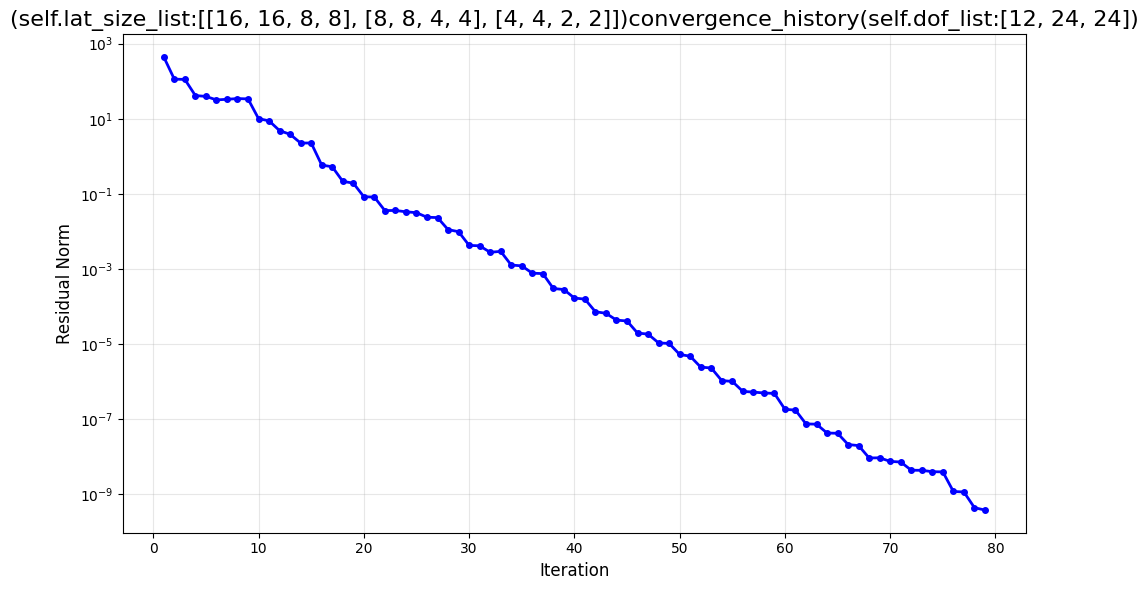

In [10]:
x = mg.solve(b=b)
mg.plot()

In [11]:
mg.num_levels

3

In [12]:
mg.convergence_history

[442.82798787465305,
 113.78845648358016,
 112.01748577478821,
 41.551962141860336,
 39.575662943596356,
 31.867775078208535,
 33.113788907874714,
 34.60095099214658,
 33.92404110609111,
 10.1140769479979,
 8.824434132508317,
 4.841936598610301,
 3.865490155498711,
 2.260282111459237,
 2.274873823914356,
 0.5877827724734103,
 0.5286083863445019,
 0.21652540606164475,
 0.19396900462583122,
 0.08445558846852488,
 0.08233983511749969,
 0.03603591341797281,
 0.03634727635824344,
 0.03346895842612261,
 0.03169348736342513,
 0.02395238501400059,
 0.023488626147231774,
 0.011232785465473209,
 0.009880621557627669,
 0.004272297301331458,
 0.004157786295587495,
 0.0027946077127794294,
 0.002961111612685072,
 0.001279163968781176,
 0.0012172806485044522,
 0.0007769272268433533,
 0.0007567980746873926,
 0.00030440920828350346,
 0.0002846289821884132,
 0.00016928831405667728,
 0.00015812738304892156,
 7.291772814362445e-05,
 6.652726049689793e-05,
 4.369386492447292e-05,
 4.146515559483708e-05,
 1

In [13]:
mg.lonv_list[0].shape

torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2])

In [14]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([-1.2520e-13-2.6279e-13j,  2.9643e-13-5.7243e-13j,
        -3.1192e-13+2.0116e-14j,  1.8571e-12-3.4450e-13j,
        -3.6204e-13-2.7023e-13j,  8.5887e-13+6.3738e-13j,
        -4.5416e-13-5.5733e-14j,  3.4128e-13-1.4710e-13j,
        -7.4651e-13-2.3545e-13j, -5.7149e-13+1.4566e-13j,
        -3.2940e-13+2.1272e-13j, -5.3763e-13+1.6160e-12j,
        -6.5103e-13+5.1398e-13j, -8.0203e-13+5.7343e-13j,
        -8.7974e-13+8.7358e-13j,  3.1775e-13-1.7322e-13j,
         1.2876e-12+8.2885e-13j,  5.5222e-13-3.7048e-13j,
         4.9782e-13-1.0303e-13j, -6.2977e-13-5.3813e-13j,
         4.1794e-13-1.2791e-12j, -2.8277e-13+5.4157e-13j,
         1.4593e-12+5.9674e-13j, -4.0623e-13+3.1453e-13j,
         1.0336e-13+9.8310e-13j, -4.5075e-13+8.0685e-13j,
        -2.0278e-13+6.5248e-13j, -6.3949e-13+6.8967e-13j,
        -9.5601e-13+6.5062e-13j, -4.5158e-13+3.2685e-13j,
         1.0475e-13+1.1241e-13j,  1.0374e-12+1.5335e-13j,
         1.0203e-12+1.5860e-13j,  8.4743e-13-3.3906e-13j,
         1.894

In [15]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

1.3333414580930933e-10


In [16]:
mg.num_levels

3

In [17]:
index = 0
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0068+0.0016j, 0.0089+0.0038j, 0.0076+0.0058j, 0.0098+0.0093j,
        0.0137+0.0036j, 0.0115+0.0033j, 0.0110+0.0004j, 0.0122+0.0022j,
        0.0132-0.0011j, 0.0102-0.0002j], device='cuda:0')
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0075-1.1641e-03j, 0.0090-9.9648e-04j, 0.0079-6.9607e-04j,
        0.0102-8.1501e-04j, 0.0087+7.2853e-04j, 0.0115-4.4556e-04j,
        0.0084+8.6118e-04j, 0.0107+4.1652e-04j, 0.0094+1.1728e-03j,
        0.0093-7.2494e-05j], device='cuda:0')
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-0.0017-0.0282j,  0.0074-0.0254j,  0.0080-0.0240j,  0.0129-0.0301j,
         0.0176-0.0185j,  0.0214-0.0164j,  0.0283-0.0078j,  0.0432-0.0037j,
         0.0435+0.0046j,  0.0334+0.0195j], device='cuda:0')
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-0.0036-8.7808e-03j,  0.0022-4.5107e-03j, -0.0002-1.1045e-02j,
         0.0051+2.1807e-03j,  0.0062-2.0535e-03j,  0.0093+3.8

In [18]:
mg.nv_list[-1].flatten()[:100]

tensor([-0.0098-0.0054j, -0.0098-0.0053j, -0.0104-0.0052j, -0.0088-0.0066j,
        -0.0084-0.0057j, -0.0093-0.0051j, -0.0103-0.0060j, -0.0095-0.0066j,
        -0.0104-0.0051j, -0.0102-0.0062j, -0.0097-0.0051j, -0.0086-0.0063j,
        -0.0081-0.0066j, -0.0087-0.0060j, -0.0080-0.0067j, -0.0095-0.0049j,
        -0.0094-0.0060j, -0.0096-0.0065j, -0.0090-0.0051j, -0.0092-0.0066j,
        -0.0094-0.0067j, -0.0084-0.0055j, -0.0086-0.0056j, -0.0093-0.0053j,
        -0.0095-0.0061j, -0.0097-0.0058j, -0.0096-0.0053j, -0.0100-0.0061j,
        -0.0091-0.0062j, -0.0084-0.0064j, -0.0090-0.0056j, -0.0080-0.0058j,
        -0.0096-0.0060j, -0.0091-0.0051j, -0.0087-0.0057j, -0.0096-0.0042j,
        -0.0095-0.0061j, -0.0097-0.0060j, -0.0103-0.0060j, -0.0107-0.0058j,
        -0.0098-0.0050j, -0.0090-0.0056j, -0.0093-0.0056j, -0.0093-0.0051j,
        -0.0091-0.0067j, -0.0102-0.0059j, -0.0102-0.0059j, -0.0103-0.0057j,
        -0.0091-0.0049j, -0.0096-0.0052j, -0.0096-0.0052j, -0.0093-0.0045j,
        -0.0

In [19]:
_null_vec = torch.randn_like(null_vecs[0])
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(499.0895, device='cuda:0')
tensor([-0.1719+1.5133j, -0.2039-0.8279j,  0.4376-0.6636j,  0.8555-0.1175j,
        -0.6184-0.1563j,  0.5415-1.0484j, -1.0705+0.6954j,  1.3827-0.4556j,
         0.4641-0.5638j,  0.3991-0.6121j,  0.0153+0.3855j, -0.2251+0.2491j,
         0.1349-1.0739j,  0.9059+1.3373j, -0.7672-1.0805j,  0.8740+0.1468j,
        -0.0862-0.1839j,  1.1470-0.2426j,  0.0688-0.0063j,  0.5199-0.5036j],
       device='cuda:0')
Norm of b:499.0894775390625
Norm of r:703.6046142578125
Norm of x0:442.5670471191406
BICGSTAB-Iteration 0: Residual = 1.212348e+02, Time = 0.012823 s
BICGSTAB-Iteration 1: Residual = 4.002323e+01, Time = 0.013252 s
BICGSTAB-Iteration 2: Residual = 8.149696e+01, Time = 0.013841 s
BICGSTAB-Iteration 3: Residual = 1.342793e+01, Time = 0.013460 s
BICGSTAB-Iteration 4: Residual = 1.383969e+01, Time = 0.013287 s
BICGSTAB-Iteration 5: Residual = 5.868612e+00, Time = 0.014146 s
BICGSTAB-Iteration 6: Residual = 3.731704e+00, Time = 0.013541 s
BICGSTAB-Iteration 7:

In [20]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:443.84820556640625
Norm of r:667.4513549804688
Norm of x0:444.11053466796875
BICGSTAB-Iteration 0: Residual = 1.449179e+02, Time = 0.013084 s
BICGSTAB-Iteration 1: Residual = 7.278412e+01, Time = 0.013967 s


BICGSTAB-Iteration 2: Residual = 6.147511e+01, Time = 0.013057 s
BICGSTAB-Iteration 3: Residual = 4.296717e+01, Time = 0.013235 s
BICGSTAB-Iteration 4: Residual = 2.653249e+01, Time = 0.013221 s
BICGSTAB-Iteration 5: Residual = 1.945655e+01, Time = 0.013779 s
BICGSTAB-Iteration 6: Residual = 4.666293e+01, Time = 0.013358 s
BICGSTAB-Iteration 7: Residual = 3.215337e+01, Time = 0.013253 s
BICGSTAB-Iteration 8: Residual = 2.752512e+01, Time = 0.013756 s
BICGSTAB-Iteration 9: Residual = 1.674754e+01, Time = 0.014076 s
BICGSTAB-Iteration 10: Residual = 1.626684e+01, Time = 0.013147 s
BICGSTAB-Iteration 11: Residual = 1.115690e+01, Time = 0.012982 s
BICGSTAB-Iteration 12: Residual = 9.066543e+00, Time = 0.013066 s
BICGSTAB-Iteration 13: Residual = 9.814178e+00, Time = 0.013016 s
BICGSTAB-Iteration 14: Residual = 1.366698e+01, Time = 0.012987 s
BICGSTAB-Iteration 15: Residual = 5.128553e+00, Time = 0.013831 s
BICGSTAB-Iteration 16: Residual = 4.994008e+00, Time = 0.013644 s
BICGSTAB-Iteration

In [21]:
_null_vec.flatten()[:100]

tensor([-0.0012+7.0097e-04j, -0.0013+5.1321e-04j, -0.0012+9.2628e-04j,
        -0.0010+7.6512e-04j, -0.0012+1.1015e-03j, -0.0017+6.3212e-04j,
        -0.0015+8.0111e-04j, -0.0018+1.0890e-03j, -0.0015+7.7607e-04j,
        -0.0017+6.5716e-04j, -0.0018+1.0076e-03j, -0.0013+5.8518e-04j,
        -0.0015+6.5090e-04j, -0.0014+9.0125e-04j, -0.0013+6.5090e-04j,
        -0.0012+7.2600e-04j, -0.0013+4.5375e-04j, -0.0013+5.1477e-04j,
        -0.0012+7.6356e-04j, -0.0014+4.8192e-04j, -0.0010+9.7068e-04j,
        -0.0015+4.2402e-04j, -0.0017+4.7566e-04j, -0.0017+9.3567e-04j,
        -0.0016+4.2559e-04j, -0.0014+9.7635e-04j, -0.0014+1.0765e-03j,
        -0.0014+7.8859e-04j, -0.0016+5.8831e-04j, -0.0015+2.7538e-04j,
        -0.0013+8.7621e-04j, -0.0015+8.3240e-04j, -0.0009+2.6286e-04j,
        -0.0013+7.2600e-04j, -0.0015+1.0640e-03j, -0.0015+9.2002e-04j,
        -0.0014+4.6627e-04j, -0.0016+3.7552e-05j, -0.0016+4.7566e-04j,
        -0.0014+1.0014e-03j, -0.0018+7.6981e-04j, -0.0014+7.9485e-04j,
      